In [167]:
from IPython.display import IFrame
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from connectLib import clusterThresh

from __future__ import print_function, unicode_literals
from builtins import open

from future import standard_library
standard_library.install_aliases()
import nibabel 

import nibabel as nib

import os
import urllib.request
import urllib.error
import urllib.parse
from nipype.interfaces.ants import Registration
import sys 
sys.path.insert(0, '../../../antsbin')

import numpy as np
from nibabel.testing import data_path
import pandas as pd 
from libtiff import TIFF
from medpy.io import save
from PIL import Image
import nibabel as nb

from mouseVis import generateVoxHist

# Algorithm

## Description 

ANTs computes high-dimensional mappings to capture the statistics of brain structure and function (or at least that's what their website say)

**Inputs** 
1. fixed image
2. moving image
3. similarity metric 
4. metric weights 
5. transformation (e.g. SyN, affine, rigid, translation) 
6. shrink factors 
7. smoothing sigmas 

**Outputs** 
1. The transformed image

**Pseudocode** 

In [75]:
#![Neighborhood Density Filter Pseudocode](neighborhoodDensityPseudo.jpg)
IFrame("ANTS_nonlinear_pseudocode.pdf", width=600, height=600)

## Actual Code

In [ ]:
#Registration Inputs
reg = Registration()
reg.inputs.fixed_image = input_images[0]
reg.inputs.moving_image = input_images[1]
reg.inputs.metric = ['Mattes'] * 3 + [['Mattes', 'CC']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']

#Run ANTs
reg.run()

#Nifty File Conversion
example_filename = os.path.join(data_path, 'examplefile.nii.gz')
img = nib.load(example_filename)
img_data = img.get_data()

## Predicted Conditions 
ANTs will work well when the key features of an object to not change (i.e. a donut doesn't become a line). 

## Predictable Data Sets

**The Good Data Set:**

**Description:** The good data set is 2 100x100 volumes containing 3 clusters with value of 1. Every other value in the volume is 0. 

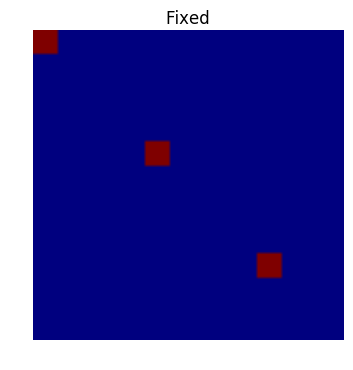

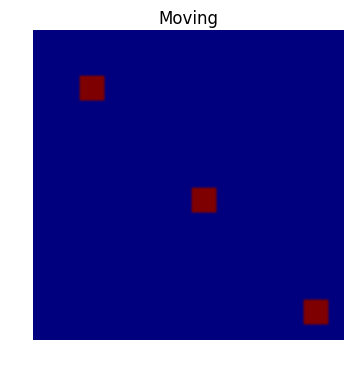

In [67]:
simEasyFixed = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        simEasyFixed[18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

simEasyMoving = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        simEasyMoving[18*(2*j) + 15: 18*(2*j + 1) + 5, 18*(2*j) + 15: 18*(2*j + 1) + 5] = 1
        
plt.imshow(simEasyFixed)
plt.axis('off')
plt.title('Fixed')
plt.show()

plt.imshow(simEasyMoving)
plt.axis('off')
plt.title('Moving')
plt.show()

**The Bad Data Set:**

**Description:** The bad data set is 2 100x100 volumes, one containing 2 clusters, one containing 3 with value of 1. Every other value in the volume is 0. 

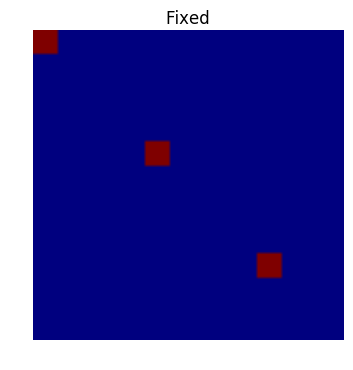

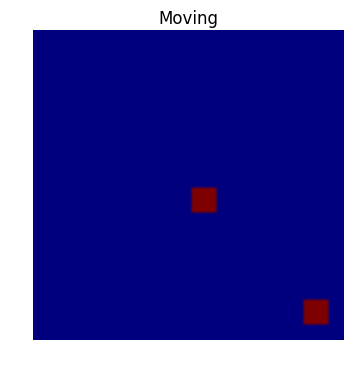

In [39]:
simBadFixed = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        simBadFixed[18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

simBadMoving = np.zeros((100, 100))
for i in range(1, 4):
    for j in range(1, 4):
        simBadMoving[18*(2*j) + 15: 18*(2*j + 1) + 5, 18*(2*j) + 15: 18*(2*j + 1) + 5] = 1
        
plt.imshow(simBadFixed)
plt.axis('off')
plt.title('Fixed')
plt.show()

plt.imshow(simBadMoving)
plt.axis('off')
plt.title('Moving')
plt.show()

### Toy Good Data Prediction
**Good Data Prediction: ** 
I predict that the good data will be perfectly aligned. 

In [71]:
scipy.misc.imsave('simEasyFixed.jpg', simEasyFixed)
scipy.misc.imsave('simEasyMoving.jpg', simEasyMoving)

In [155]:
reg = Registration()
reg.inputs.fixed_image = 'simEasyFixed.jpg'
reg.inputs.moving_image = 'simEasyMoving.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'EASY_SIM.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3)
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 
reg.inputs.metric_weight = [1] * 3 
reg.inputs.radius_or_number_of_bins = [32] * 3
reg.inputs.sampling_strategy = ['Regular'] * 3 
reg.inputs.sampling_percentage = [0.3] * 3 
reg.inputs.convergence_threshold = [1.e-8] * 3 
reg.inputs.convergence_window_size = [20] * 3 
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 
reg.inputs.sigma_units = ['vox'] * 3
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 
reg.inputs.use_estimate_learning_rate_once = [True] * 3
reg.inputs.use_histogram_matching = [False] * 3 
reg.inputs.initial_moving_transform_com = True

In [156]:
reg.run()

In [157]:
example_filename = os.path.join('EASY_SIM.nii.gz')
img = nib.load(example_filename)
easyImgData = img.get_data()

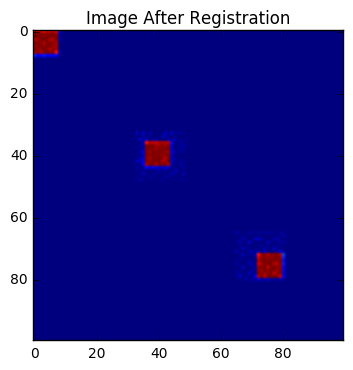

In [158]:
plt.imshow(easyImgData)
plt.title('Image After Registration')
plt.show()

## Easy Simulation Analysis

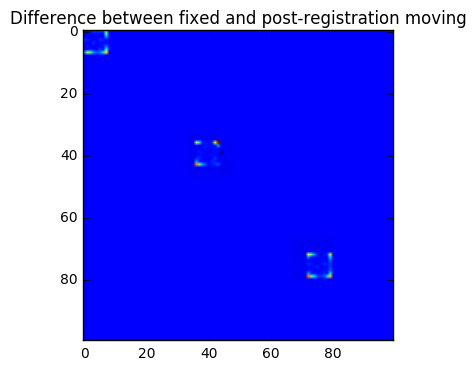

In [143]:
easyDifference = simEasyFixed - easyImgData/256
plt.imshow(easyDifference)
plt.title('Difference between fixed and post-registration moving')
plt.show()

As predicted, the data registered functionally perfectly. There are some boundary issues, but those are irrelevant to the problem we are trying solve. 

### Toy Bad Data Prediction
**Bad Data Prediction: ** 
I predict that the bad data will only register 2 of the clusters.

In [88]:
scipy.misc.imsave('simBadFixed.jpg', simBadFixed)
scipy.misc.imsave('simBadMoving.jpg', simBadMoving)

In [120]:
reg = Registration()
reg.inputs.fixed_image = 'simBadFixed.jpg'
reg.inputs.moving_image = 'simBadMoving.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'DIFF_SIM.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3)
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 
reg.inputs.metric_weight = [1] * 3 
reg.inputs.radius_or_number_of_bins = [32] * 3
reg.inputs.sampling_strategy = ['Regular'] * 3 
reg.inputs.sampling_percentage = [0.3] * 3 
reg.inputs.convergence_threshold = [1.e-8] * 3 
reg.inputs.convergence_window_size = [20] * 3 
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 
reg.inputs.sigma_units = ['vox'] * 3
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 
reg.inputs.use_estimate_learning_rate_once = [True] * 3
reg.inputs.use_histogram_matching = [False] * 3 
reg.inputs.initial_moving_transform_com = True

In [121]:
reg.run()

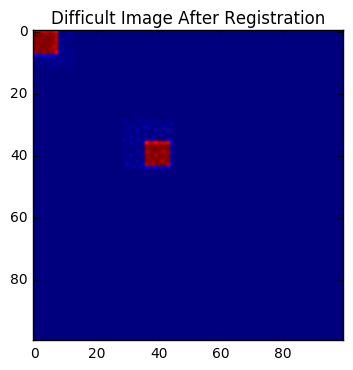

In [122]:
diff_sim_reg = os.path.join('DIFF_SIM.nii.gz')
img = nib.load(diff_sim_reg)
img_data_diff = img.get_data()
plt.imshow(img_data_diff)
plt.title('Difficult Image After Registration')
plt.show()

## Difficult Simulation Analysis

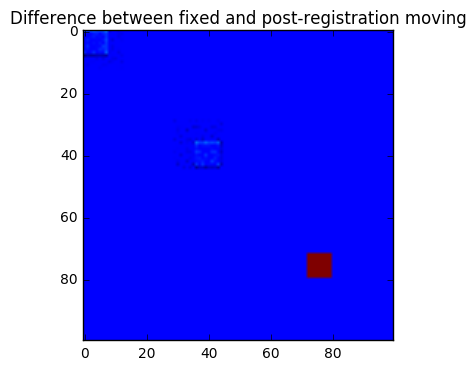

In [123]:
diffDifference = simBadFixed - img_data_diff/256
plt.imshow(diffDifference)
plt.title('Difference between fixed and post-registration moving')
plt.show()

## Showing Nonlinear Might Not Always Be Good

In [53]:
reg = Registration()
reg.inputs.fixed_image = 'simBadFixed.jpg'
reg.inputs.moving_image = 'simBadMoving.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'DIFF_SIM_WARPED.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3 + [[100, 50, 30]])
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 + [['MeanSquares', 'MI']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.0000001]
reg.inputs.convergence_window_size = [20] * 3 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 4
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 4
reg.inputs.use_histogram_matching = [False] * 3 + [True]
reg.inputs.initial_moving_transform_com = True

In [54]:
reg.run()

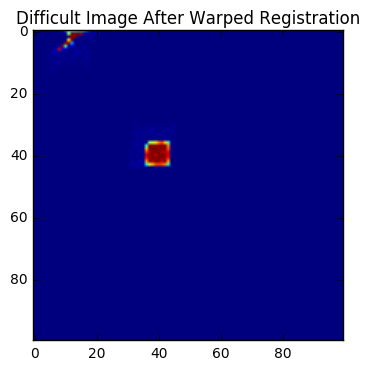

In [55]:
diff_sim_reg = os.path.join('DIFF_SIM_WARPED.nii.gz')
img = nib.load(diff_sim_reg)
img_data_diff = img.get_data()
plt.imshow(img_data_diff)
plt.title('Difficult Image After Warped Registration')
plt.show()

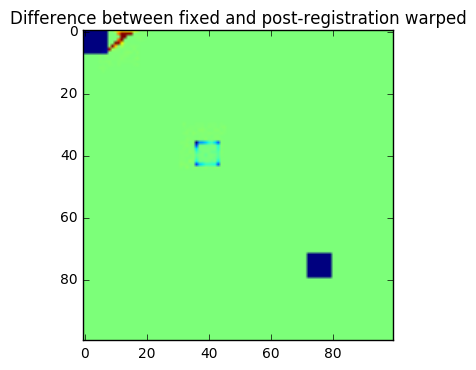

In [58]:
easyDifference = img_data_diff/256 - simBadFixed
plt.imshow(easyDifference)
plt.title('Difference between fixed and post-registration warped')
plt.show()

Sometimes, include nonlinear registration isn't always the best option. In particular, when the transformation is is not injective.

## Showing Somtimes Nonlinear Is Good

In [62]:
reg = Registration()
reg.inputs.fixed_image = 'simEasyFixed.jpg'
reg.inputs.moving_image = 'simEasyMoving.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'EASY_SIM_WARPED.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3 + [[100, 50, 30]])
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 + [['MeanSquares', 'MI']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.0000001]
reg.inputs.convergence_window_size = [20] * 3 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 4
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 4
reg.inputs.use_histogram_matching = [False] * 3 + [True]
reg.inputs.initial_moving_transform_com = True

In [63]:
reg.run()

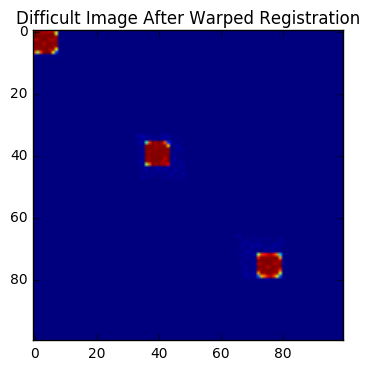

In [65]:
diff_sim_reg = os.path.join('EASY_SIM_WARPED.nii.gz')
img = nib.load(diff_sim_reg)
img_data_diff = img.get_data()
plt.imshow(img_data_diff)
plt.title('Difficult Image After Warped Registration')
plt.show()

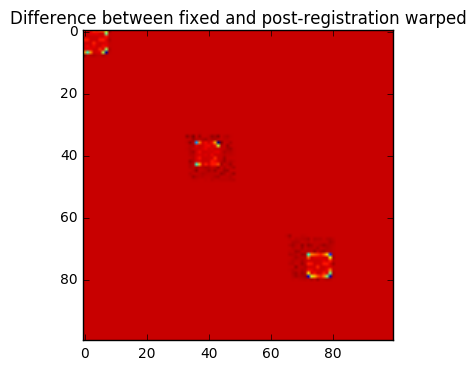

In [68]:
easyDifference = img_data_diff/256 - simEasyFixed
plt.imshow(easyDifference)
plt.title('Difference between fixed and post-registration warped')
plt.show()

Sometimes, including the nonlinear step can produce good results as well.

## Difficult Simulation 2:
Another difficult simulation to show which cases ANTs will not work in.  

**Description** This simulation have the same fixed image but the moving image will have the boxes overlapping. This means that the objects in the moving object will become fundamentally different than the original image.

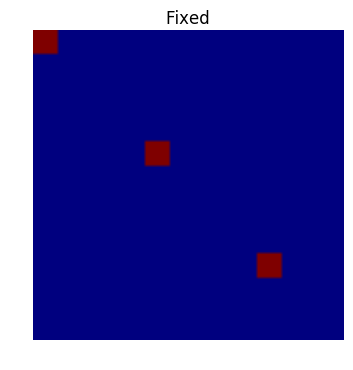

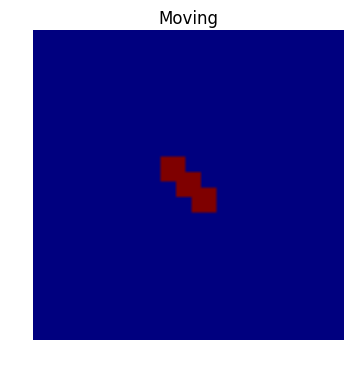

In [3]:
simBadFixed2 = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        simBadFixed2[18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

simBadMoving2 = np.zeros((100, 100))
simBadMoving2[18*(2*1) + 15: 18*(2*1 + 1) + 5, 18*(2*1) + 15: 18*(2*1 + 1) + 5] = 1
simBadMoving2[18*(2*1) + 10: 18*(2*1 + 1) + 0, 18*(2*1) + 10: 18*(2*1 + 1) + 0] = 1
simBadMoving2[18*(2*1) + 5: 18*(2*1 + 1) - 5, 18*(2*1) + 5: 18*(2*1 + 1) - 5] = 1

plt.imshow(simBadFixed2)
plt.axis('off')
plt.title('Fixed')
plt.show()

plt.imshow(simBadMoving2)
plt.axis('off')
plt.title('Moving')
plt.show()

In [4]:
scipy.misc.imsave('simBadFixed2.jpg', simBadFixed2)
scipy.misc.imsave('simBadMoving2.jpg', simBadMoving2)

In [5]:
reg = Registration()
reg.inputs.fixed_image = 'simBadFixed2.jpg'
reg.inputs.moving_image = 'simBadMoving2.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'DIFF_SIM2.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3)
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 
reg.inputs.metric_weight = [1] * 3 
reg.inputs.radius_or_number_of_bins = [32] * 3
reg.inputs.sampling_strategy = ['Regular'] * 3 
reg.inputs.sampling_percentage = [0.3] * 3 
reg.inputs.convergence_threshold = [1.e-8] * 3 
reg.inputs.convergence_window_size = [20] * 3 
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 
reg.inputs.sigma_units = ['vox'] * 3
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 
reg.inputs.use_estimate_learning_rate_once = [True] * 3
reg.inputs.use_histogram_matching = [False] * 3 
reg.inputs.initial_moving_transform_com = True
reg.run()

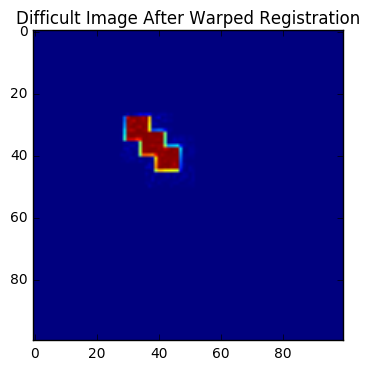

In [7]:
diff_sim_reg2 = os.path.join('DIFF_SIM2.nii.gz')
img = nib.load(diff_sim_reg2)
img_data_diff2 = img.get_data()
plt.imshow(img_data_diff2)
plt.title('Difficult Image After Warped Registration')
plt.show()

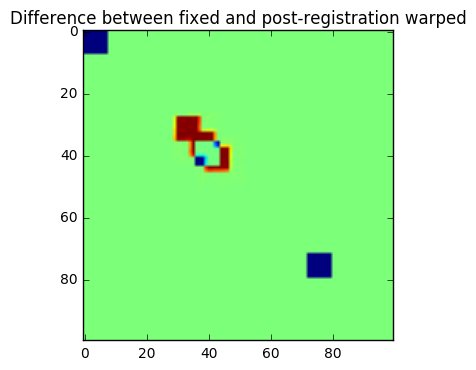

In [8]:
diffDifference = img_data_diff2/256 - simBadFixed2
plt.imshow(diffDifference)
plt.title('Difference between fixed and post-registration warped')
plt.show()

In [9]:
reg = Registration()
reg.inputs.fixed_image = 'simBadFixed2.jpg'
reg.inputs.moving_image = 'simBadMoving2.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'DIFF_SIM_WARPED2.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3 + [[100, 50, 30]])
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 + [['MeanSquares', 'MI']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.0000001]
reg.inputs.convergence_window_size = [20] * 3 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 4
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 4
reg.inputs.use_histogram_matching = [False] * 3 + [True]
reg.inputs.initial_moving_transform_com = True

In [10]:
reg.run()

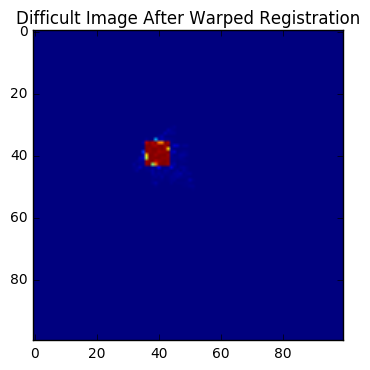

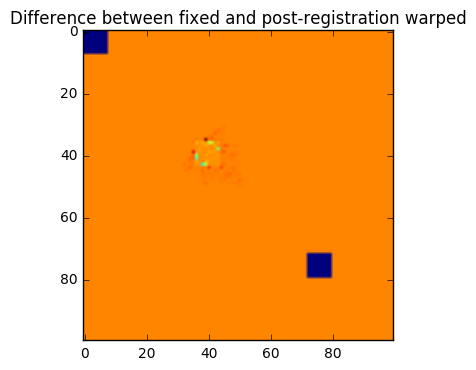

In [11]:
diff_sim_reg2warped = os.path.join('DIFF_SIM_WARPED2.nii.gz')
img = nib.load(diff_sim_reg2warped)
img_data_diff2warped = img.get_data()
plt.imshow(img_data_diff2warped)
plt.title('Difficult Image After Warped Registration')
plt.show()

diffDifference2 = img_data_diff2warped/256 - simBadFixed2
plt.imshow(diffDifference2)
plt.title('Difference between fixed and post-registration warped')
plt.show()

## Difficult Simulation Analysis:
As expected, when the objects are no longer the same, it becomes increasingly difficult to register the objects. However, this problem should not affect our data since synapses only grown brighter or darker and do not actually move. One interesting thing to note is that when you add nonlinear registration, the boxes are warped together to increase the similarity. 

## Real Data

### Load data, convert to proper format

In [122]:
import sys
sys.path.append('../code/functions')

import pickle

import matplotlib.pyplot as plt

from tiffIO import loadTiff, unzipChannels
from connectLib import adaptiveThreshold

import numpy as np

In [119]:
tp2ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp2.tif'))
tp3ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp3.tif'))

In [120]:
#First slice only
tp2slice = tp2ChanList[1][:5]
tp3slice = tp3ChanList[1][:5]

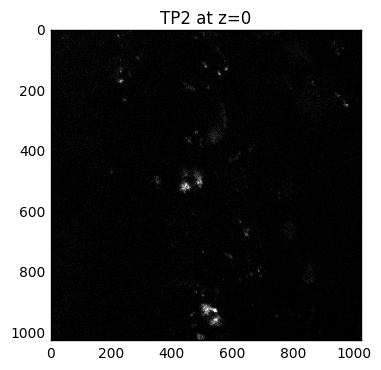

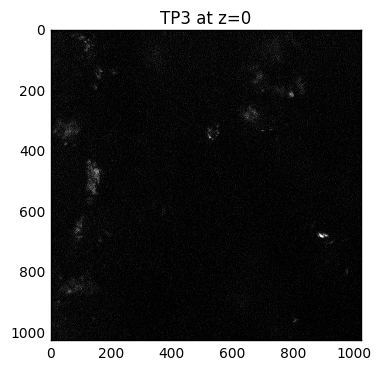

In [121]:
fig = plt.figure()
plt.imshow(tp2slice[0], cmap='gray')
plt.title('TP2 at z=0')
plt.show()

fig = plt.figure()
plt.imshow(tp3slice[0], cmap='gray')
plt.title('TP3 at z=0')
plt.show()

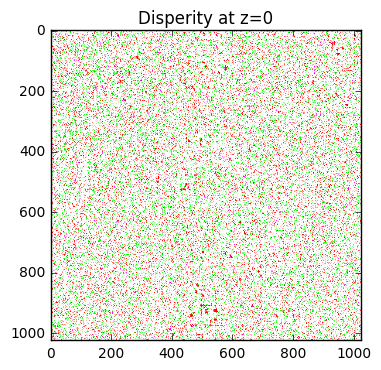

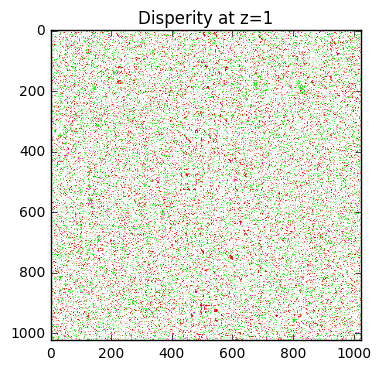

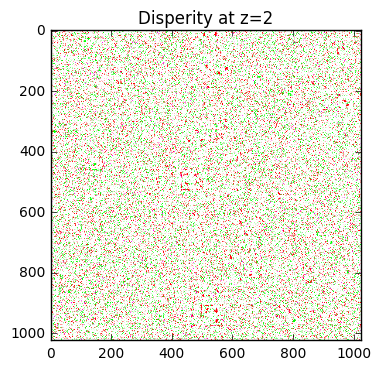

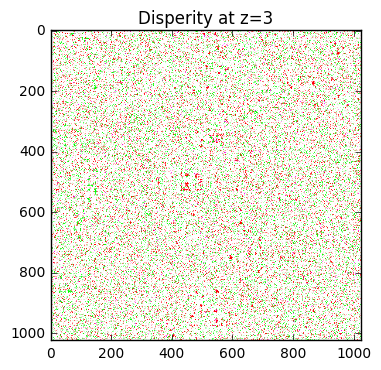

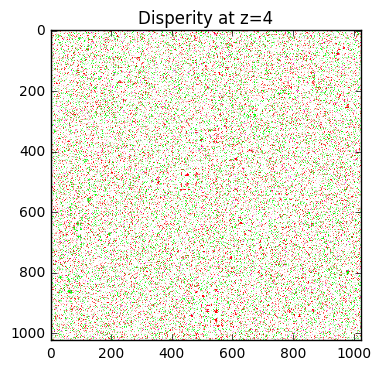

In [92]:
import cv2
## Visualization functions:
def toDiff(imgA, imgB):
    ret = np.empty((imgA.shape[0], imgA.shape[1], 3), dtype=np.uint8)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            
            if imgA[y][x] and not imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 0
            elif not imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            elif imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 255
            else:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 255
            
    return ret

def visDiff(sliceA, sliceB):
    disp = toDiff(sliceA, sliceB)
    return disp

def visVolDiff(volumeA, volumeB):
    for i in range(volumeA.shape[0]):
        plt.figure()
        plt.title('Disperity at z=' + str(i))
        plt.imshow(visDiff(volumeA[i], volumeB[i]))
        plt.show()

visVolDiff(adaptiveThreshold(tp2slice, 64, 64, 90), adaptiveThreshold(tp3slice, 64, 64, 90))

### Running ANTs (linear only)

In [123]:
adaptive2 = adaptiveThreshold(tp2slice, 64, 64, 90)
img2 = nib.Nifti1Image(adaptive2, np.eye(4))
nb.save(img2, 'tp2.nii')
adaptive3 = adaptiveThreshold(tp3slice, 64, 64, 90)
img3 = nib.Nifti1Image(adaptive3, np.eye(4))
nb.save(img3, 'tp3.nii')

In [164]:
reg = Registration()
reg.inputs.fixed_image = 'tp2.nii'
reg.inputs.moving_image = 'tp3.nii'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'tp2to3_registered.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3)
reg.inputs.dimension = 3
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MeanSquares'] * 3 
reg.inputs.metric_weight = [1] * 3 
reg.inputs.radius_or_number_of_bins = [32] * 3
reg.inputs.sampling_strategy = ['Regular'] * 3 
reg.inputs.sampling_percentage = [0.3] * 3 
reg.inputs.convergence_threshold = [1.e-8] * 3 
reg.inputs.convergence_window_size = [20] * 3 
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 
reg.inputs.sigma_units = ['vox'] * 3
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 
reg.inputs.use_estimate_learning_rate_once = [True] * 3
reg.inputs.use_histogram_matching = [False] * 3 
reg.inputs.initial_moving_transform_com = True
reg.run()

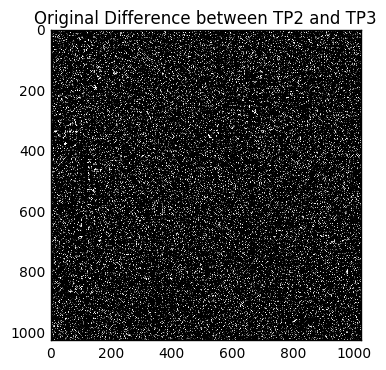

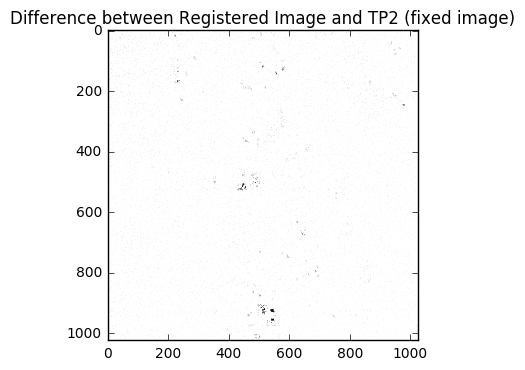

In [169]:
real_registered = os.path.join('tp2to3_registered.nii.gz')
img = nib.load(real_registered)
real_registered_img = img.get_data()


difference = adaptiveThreshold(tp2slice, 64, 64, 90)[0] - adaptiveThreshold(tp3slice, 64, 64, 90)[0]
plt.imshow(difference, cmap='gray')
plt.title('Original Difference between TP2 and TP3')
plt.show()

difference = real_registered_img - adaptiveThreshold(tp2slice, 64, 64, 90)[0]
plt.imshow(difference[0], cmap = 'gray')
plt.title('Difference between Registered Image and TP2 (fixed image)')
plt.show()

In [138]:
def precision_recall_f1(labels, predictions, overlapRatio=1):
   

    if len(predictions) == 0:
        print('ERROR: prediction list is empty')
        return 0., 0., 0.
    
    labelFound = np.zeros(len(labels))
    truePositives = 0
    falsePositives = 0

    for prediction in predictions:
        #casting to set is ok here since members are uinque
        predictedMembers = set([tuple(elem) for elem in prediction.getMembers()])
        detectionCutoff = overlapRatio * len(predictedMembers)
        found = False
        
        for idx, label in enumerate(labels):
            labelMembers = set([tuple(elem) for elem in label.getMembers()])
            #if the predictedOverlap is over the detectionCutoff ratio
            if len(predictedMembers & labelMembers) >= detectionCutoff:
                truePositives +=1
                found=True
                labelFound[idx] = 1
        
        if not found:
            falsePositives +=1
            
    precision = truePositives/float(truePositives + falsePositives)
    recall = np.count_nonzero(labelFound)/float(len(labels))
    f1 = 0
    try:
        f1 = 2 * (precision*recall)/(precision + recall)
        
    except ZeroDivisionError:
        f1 = 0
        
    return precision, recall, f1

In [143]:
labels = clusterThresh(adaptiveThreshold(tp2slice, 64, 64, 90), lowerFence = 20, upperFence = 180)

In [145]:
print(real_registered_img.shape)

(1024, 1024)


## Showing When ANTs Does Not Work

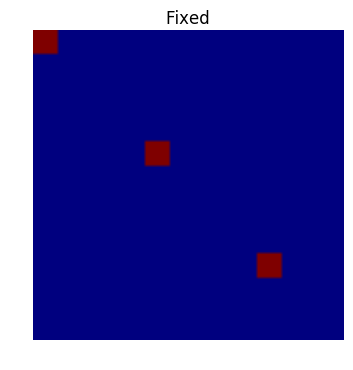

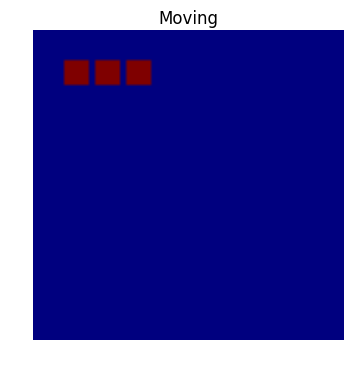

In [66]:
regTestFixed = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        regTestFixed[18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

regTestMoving = np.zeros((100, 100))
regTestMoving[10:18, 10: 18] = 1
regTestMoving[10:18, 20: 28] = 1
regTestMoving[10:18, 30:38] = 1
        
plt.imshow(regTestFixed)
plt.axis('off')
plt.title('Fixed')
plt.show()

plt.imshow(regTestMoving)
plt.axis('off')
plt.title('Moving')
plt.show()

In [67]:
scipy.misc.imsave('regFixed.jpg', regTestFixed)
scipy.misc.imsave('regMoving.jpg', regTestMoving)

In [68]:
reg = Registration()
reg.inputs.fixed_image = 'regFixed.jpg'
reg.inputs.moving_image = 'regMoving.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'Reg_Test.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3)
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 
reg.inputs.metric_weight = [1] * 3 
reg.inputs.radius_or_number_of_bins = [32] * 3
reg.inputs.sampling_strategy = ['Regular'] * 3 
reg.inputs.sampling_percentage = [0.3] * 3 
reg.inputs.convergence_threshold = [1.e-8] * 3 
reg.inputs.convergence_window_size = [20] * 3 
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 
reg.inputs.sigma_units = ['vox'] * 3
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 
reg.inputs.use_estimate_learning_rate_once = [True] * 3
reg.inputs.use_histogram_matching = [False] * 3 
reg.inputs.initial_moving_transform_com = True
reg.run()

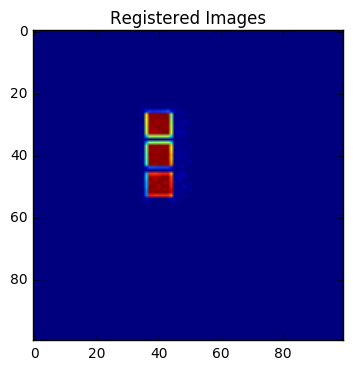

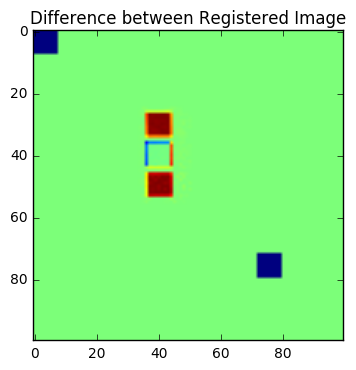

In [73]:
registered = os.path.join('Reg_Test.nii.gz')
img = nib.load(registered)
registered_img = img.get_data()
plt.imshow(registered_img)
plt.title('Registered Images')
plt.show()

difference = registered_img/256 - regTestFixed
plt.imshow(difference)
plt.title('Difference between Registered Image')
plt.show()

In [72]:
reg = Registration()
reg.inputs.fixed_image = 'regFixed.jpg'
reg.inputs.moving_image = 'regMoving.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'Reg_Warped.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3 + [[100, 50, 30]])
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 + [['MeanSquares', 'MI']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.0000001]
reg.inputs.convergence_window_size = [20] * 3 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 4
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 4
reg.inputs.use_histogram_matching = [False] * 3 + [True]
reg.inputs.initial_moving_transform_com = True
reg.run()

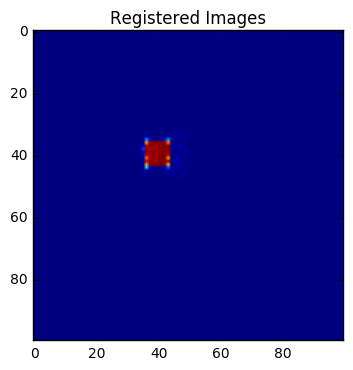

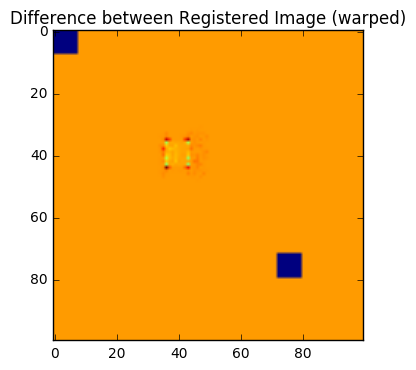

In [74]:
registered = os.path.join('Reg_Warped.nii.gz')
img = nib.load(registered)
registered_img = img.get_data()
plt.imshow(registered_img)
plt.title('Registered Images')
plt.show()

difference = registered_img/256 - regTestFixed
plt.imshow(difference)
plt.title('Difference between Registered Image (warped)')
plt.show()